<a href="https://colab.research.google.com/github/msaad1311/tester/blob/main/Upwork_Role.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python main.py

In [ ]:
lsc = 12.54
rp = 6.36
th = 26.9

### Testing out using the scripts created

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
## config
LOCATION = ["lsc", "rp", "th"]
SEQUENCE_LENGTH = 4 * 24  # identify as a day
TARGET_COLUMN = "Load"
TRAIN_SIZE = 0.8
OPTIMIZER = "adam"
MODEL_LOSS = "mean_squared_error"
MODEL_EPOCHS = 200
MODEL_BATCH_SIZE = 128
VALIDATION_SPLIT = 0.1
NUM_TIME_PERIOD = SEQUENCE_LENGTH * 31
CONSIDERED_COLUMNS = ["date", "temp", "load", "location"]

## Utils

def load_data(location):
    load = pd.read_csv(f"/content/data/{location}2.csv")
    temp = pd.read_csv(f"/content/data/{location}_temp_w_may.csv")

    if "Datetime MST" in load.columns:
        load["date"] = pd.to_datetime(load["Datetime MST"], format="%m/%d/%Y %H:%M")
    elif "Datetime EST" in load.columns:
        load["date"] = pd.to_datetime(load["Datetime EST"], format="%m/%d/%Y %H:%M")
    else:
        raise ValueError("Unable to find the datetime column in temp file")

    temp["date"] = pd.to_datetime(temp["time"])

    temp.drop(["time"], axis=1, inplace=True)
    temp.set_index("date", inplace=True)

    # Create a new DataFrame with the desired index
    new_index = pd.date_range(start=temp.index[0], end='2023-06-01 00:00', freq='15T')
    resampled_data = pd.DataFrame(index=new_index)

    # Merge the original data with the new DataFrame
    temp = resampled_data.merge(temp, how='left', left_index=True, right_index=True)

    # Forward fill to maintain the same temperature within each hour
    temp.fillna(method='ffill', inplace=True)

    # Reset the index to make 'date' a regular column
    temp.reset_index(inplace=True)
    temp.rename(columns={'index':'date'},inplace=True)

    combined = pd.merge(left=load, right=temp, on=["date"], how="left")
    combined["temp"] = combined["temp"].fillna(method="ffill").fillna(method="bfill")

    # Filter data out the May 2023
    combined_april = combined[
        (combined["date"].dt.year == 2023) & (combined["date"].dt.month <= 5)
    ]

    combined_may = temp[
        (temp["date"].dt.year == 2023) & (temp["date"].dt.month == 5)
    ]

    df_features = combined[["date","temp", "Load"]].dropna().reset_index(drop=True)

    return df_features,combined_may


def preprocess_data(df_features):
    X = []
    y = []
    sequence_length = SEQUENCE_LENGTH

    for i in range(sequence_length, len(df_features)):
        X.append(df_features.iloc[i - sequence_length : i, :].values)
        y.append(df_features.loc[i, TARGET_COLUMN])

    X = np.array(X)
    y = np.array(y)

    return X, y


def split_data(X, y):
    train_size = int(TRAIN_SIZE * len(X))
    x_train, x_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return x_train, x_test, y_train, y_test


def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=32))
    model.add(Dense(units=1))
    model.compile(optimizer=OPTIMIZER, loss=MODEL_LOSS)

    return model


def train_model(model, x_train, y_train,location):
    earlyStopping = EarlyStopping(monitor="val_loss", patience=5, verbose=0, mode="min")
    model_save = ModelCheckpoint(
        f"{location}.hdf5", save_best_only=True, monitor="val_loss", mode="min"
    )

    history = model.fit(
        x_train,
        y_train,
        epochs=MODEL_EPOCHS,
        batch_size=MODEL_BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        callbacks=[earlyStopping, model_save],
    )

    return history


def plot_loss(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("Loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"])
    plt.show()


def evaluate_model(model, x_test, y_test):
    loss = model.evaluate(x_test, y_test)
    print("Test loss:", loss)


def make_predictions(model, x_test):
    predictions = model.predict(x_test)
    return predictions


def calculate_metric(y_test, predictions):
    comparison = pd.DataFrame(
        {"Actual": y_test.flatten(), "Predicted": predictions.flatten()}
    )
    metric = mse(comparison["Actual"], comparison["Predicted"], squared=False)
    print(f"The metric is {round(metric, 2)}")
    return metric


def perform_rolling_forecast(model, df_features,location,may_temp):
    model.load_weights(f"{location}.hdf5")
    num_time_periods = (
        NUM_TIME_PERIOD
    )  # Number of 15-minute intervals in May 2023 (assuming 31 days)
    sequence_length = SEQUENCE_LENGTH
    rolling_forecast_input = df_features[['temp','Load']].iloc[-sequence_length:].values
    X_rolling_forecast = np.array([rolling_forecast_input])

    rolling_forecast_predictions = []
    load_may_values = []
    for i in tqdm(range(num_time_periods)):
        prediction = model.predict(X_rolling_forecast, verbose=0)
        rolling_forecast_predictions.extend(prediction[0])
        load_may_values.append(prediction[0])
        new_sample = np.append(may_temp.iloc[i,1], prediction[0])
        new_sample = np.expand_dims(new_sample, axis=(0, 1))
        X_rolling_forecast = np.concatenate(
            [X_rolling_forecast[:, 1:, :], new_sample], axis=1
        )

    inference_result = load_may_values
    inference_result = pd.DataFrame(inference_result, columns=["load"])
    inference_result["date"] = pd.date_range(
        start="2023-05-01", end="2023-06-01", freq="15T", inclusive="both"
    )[:-1]
    inference_result["location"] = location
    inference_result["temp"] = 34
    inference_result = inference_result[CONSIDERED_COLUMNS]

    return inference_result

def file_save(title,df):
    # Specify the directory path and file name
    directory = '/content/results'
    filepath = os.path.join(directory, title)

    # Create the directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    # Save the DataFrame to CSV
    df.to_csv(filepath, index=False)
    return

------------------------------ Working on lsc ------------------------------
Epoch 1/200
230/230 [==============================] - 7s 13ms/step - loss: 8510.9775 - val_loss: 3718.0312
Epoch 2/200
230/230 [==============================] - 2s 10ms/step - loss: 7257.9834 - val_loss: 3040.3989
Epoch 3/200
230/230 [==============================] - 2s 10ms/step - loss: 6382.9658 - val_loss: 2513.7161
Epoch 4/200
230/230 [==============================] - 3s 12ms/step - loss: 5660.6382 - val_loss: 2106.0510
Epoch 5/200
230/230 [==============================] - 2s 10ms/step - loss: 5064.4414 - val_loss: 1800.1219
Epoch 6/200
230/230 [==============================] - 2s 10ms/step - loss: 4575.8848 - val_loss: 1578.6946
Epoch 7/200
230/230 [==============================] - 3s 12ms/step - loss: 4181.5796 - val_loss: 1429.1010
Epoch 8/200
230/230 [==============================] - 2s 10ms/step - loss: 3755.8074 - val_loss: 1005.9372
Epoch 9/200
230/230 [==============================] - 3s 1

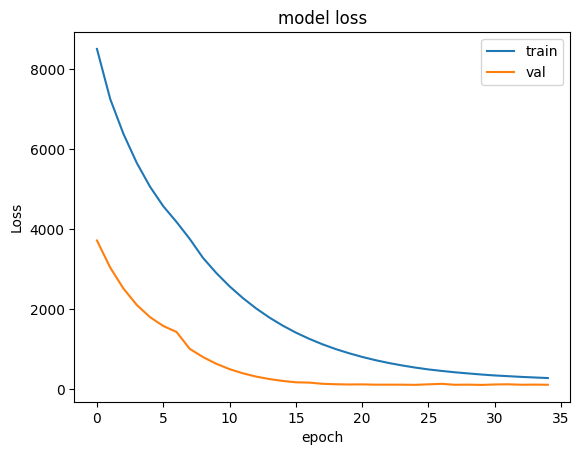

255/255 [==============================] - 1s 5ms/step - loss: 153.4554
Test loss: 153.45535278320312
255/255 [==============================] - 2s 4ms/step
The metric is 12.39
Epoch 1/200
287/287 [==============================] - 7s 14ms/step - loss: 7639.9492 - val_loss: 5819.0874
Epoch 2/200
287/287 [==============================] - 3s 11ms/step - loss: 6331.1992 - val_loss: 4858.7505
Epoch 3/200
287/287 [==============================] - 3s 10ms/step - loss: 5420.3379 - val_loss: 4112.0288
Epoch 4/200
287/287 [==============================] - 3s 10ms/step - loss: 4703.8511 - val_loss: 3535.0703
Epoch 5/200
287/287 [==============================] - 3s 10ms/step - loss: 4147.7852 - val_loss: 3100.4216
Epoch 6/200
287/287 [==============================] - 3s 12ms/step - loss: 3725.8135 - val_loss: 2782.9839
Epoch 7/200
287/287 [==============================] - 3s 10ms/step - loss: 3414.9724 - val_loss: 2561.3467
Epoch 8/200
287/287 [==============================] - 3s 10ms/step

100%|██████████| 2976/2976 [03:39<00:00, 13.57it/s]


------------------------------ Working on rp ------------------------------
Epoch 1/200
63/63 [==============================] - 6s 25ms/step - loss: 9688.3701 - val_loss: 13582.9697
Epoch 2/200
63/63 [==============================] - 1s 11ms/step - loss: 8767.0098 - val_loss: 12917.5371
Epoch 3/200
63/63 [==============================] - 1s 11ms/step - loss: 8310.2764 - val_loss: 12396.5596
Epoch 4/200
63/63 [==============================] - 1s 10ms/step - loss: 7916.0801 - val_loss: 11921.3232
Epoch 5/200
63/63 [==============================] - 1s 11ms/step - loss: 7550.2319 - val_loss: 11471.8760
Epoch 6/200
63/63 [==============================] - 1s 11ms/step - loss: 7204.6660 - val_loss: 11043.0518
Epoch 7/200
63/63 [==============================] - 1s 11ms/step - loss: 6875.0835 - val_loss: 10630.3164
Epoch 8/200
63/63 [==============================] - 1s 11ms/step - loss: 6559.9785 - val_loss: 10233.8525
Epoch 9/200
63/63 [==============================] - 1s 11ms/step - 

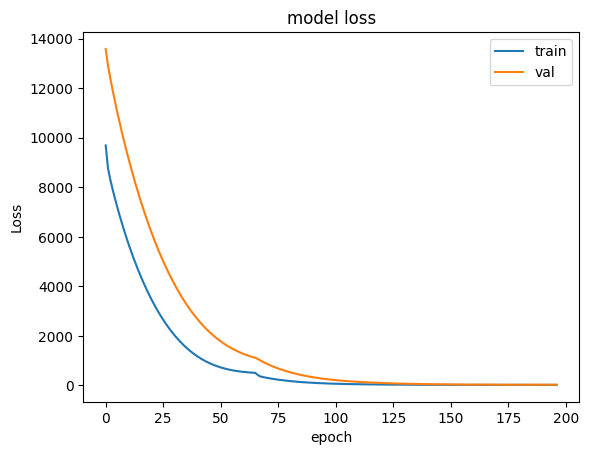

69/69 [==============================] - 0s 7ms/step - loss: 44.3678
Test loss: 44.3678092956543
69/69 [==============================] - 1s 5ms/step
The metric is 6.66
Epoch 1/200
78/78 [==============================] - 5s 21ms/step - loss: 10814.6533 - val_loss: 13278.7461
Epoch 2/200
78/78 [==============================] - 1s 10ms/step - loss: 9682.7354 - val_loss: 12511.1514
Epoch 3/200
78/78 [==============================] - 1s 10ms/step - loss: 9116.3330 - val_loss: 11896.7041
Epoch 4/200
78/78 [==============================] - 1s 10ms/step - loss: 8617.6104 - val_loss: 11329.5098
Epoch 5/200
78/78 [==============================] - 1s 11ms/step - loss: 8153.8784 - val_loss: 10795.0479
Epoch 6/200
78/78 [==============================] - 1s 10ms/step - loss: 7716.7144 - val_loss: 10287.1309
Epoch 7/200
78/78 [==============================] - 1s 11ms/step - loss: 7302.1641 - val_loss: 9802.8213
Epoch 8/200
78/78 [==============================] - 1s 14ms/step - loss: 6908.178

100%|██████████| 2976/2976 [02:53<00:00, 17.18it/s]


------------------------------ Working on th ------------------------------
Epoch 1/200
312/312 [==============================] - 8s 13ms/step - loss: 364410.4688 - val_loss: 204856.8438
Epoch 2/200
312/312 [==============================] - 3s 10ms/step - loss: 350436.8438 - val_loss: 195222.0000
Epoch 3/200
312/312 [==============================] - 4s 12ms/step - loss: 338401.2500 - val_loss: 186249.1719
Epoch 4/200
312/312 [==============================] - 3s 10ms/step - loss: 326926.7188 - val_loss: 177652.6094
Epoch 5/200
312/312 [==============================] - 3s 10ms/step - loss: 315818.0312 - val_loss: 169360.4375
Epoch 6/200
312/312 [==============================] - 3s 10ms/step - loss: 305030.0938 - val_loss: 161343.2812
Epoch 7/200
312/312 [==============================] - 4s 13ms/step - loss: 294515.5625 - val_loss: 153573.9531
Epoch 8/200
312/312 [==============================] - 3s 10ms/step - loss: 284271.4375 - val_loss: 146048.5312
Epoch 9/200
312/312 [=======

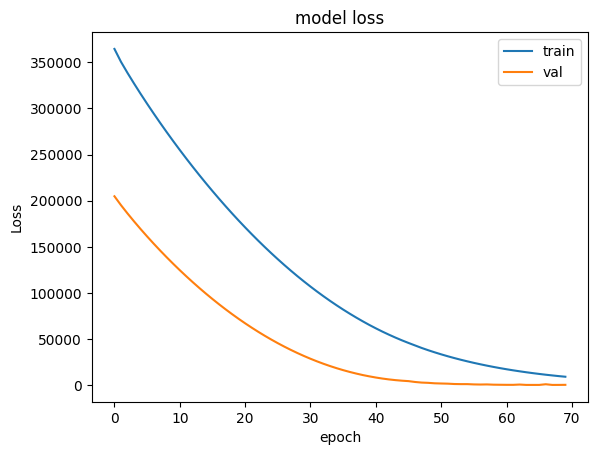

346/346 [==============================] - 2s 5ms/step - loss: 960.0109
Test loss: 960.0108642578125
346/346 [==============================] - 2s 4ms/step
The metric is 30.98
Epoch 1/200
389/389 [==============================] - 9s 12ms/step - loss: 327314.2500 - val_loss: 222209.3438
Epoch 2/200
389/389 [==============================] - 4s 11ms/step - loss: 311715.0625 - val_loss: 210295.7188
Epoch 3/200
389/389 [==============================] - 4s 11ms/step - loss: 298027.1562 - val_loss: 199013.7031
Epoch 4/200
389/389 [==============================] - 4s 10ms/step - loss: 284918.5312 - val_loss: 188210.2500
Epoch 5/200
389/389 [==============================] - 4s 10ms/step - loss: 272278.0938 - val_loss: 177824.1562
Epoch 6/200
389/389 [==============================] - 4s 11ms/step - loss: 260056.8438 - val_loss: 167821.7344
Epoch 7/200
389/389 [==============================] - 4s 10ms/step - loss: 248222.8125 - val_loss: 158182.5156
Epoch 8/200
389/389 [===================

100%|██████████| 2976/2976 [03:49<00:00, 12.97it/s]


In [ ]:
for loc in LOCATION:
    print("-" * 30, f"Working on {loc}", "-" * 30)

    # Load and preprocess data
    df_features, may_temp = load_data(loc)
    X, y = preprocess_data(df_features[['temp','Load']])

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = split_data(X, y)

    # Build the LSTM model
    model = build_model((x_train.shape[1], x_train.shape[2]))

    # Train the model
    history = train_model(model, x_train, y_train, loc)

    # Plot the training and validation loss
    plot_loss(history)

    # Evaluate the model on the test set
    evaluate_model(model, x_test, y_test)

    # Make predictions on the test set
    predictions = make_predictions(model, x_test)

    # Calculate the metric
    metric = calculate_metric(y_test, predictions)

    # Build the LSTM model
    model_retrain = build_model((X.shape[1], X.shape[2]))

    # Model retrain on whole dataset
    history_retrain = train_model(model_retrain, X, y, loc)

    # Perform rolling forecast inference for May 2023
    inference_result = perform_rolling_forecast(model, df_features[['temp','Load']], loc,may_temp)

    file_save(f'{loc}_results.csv',inference_result)


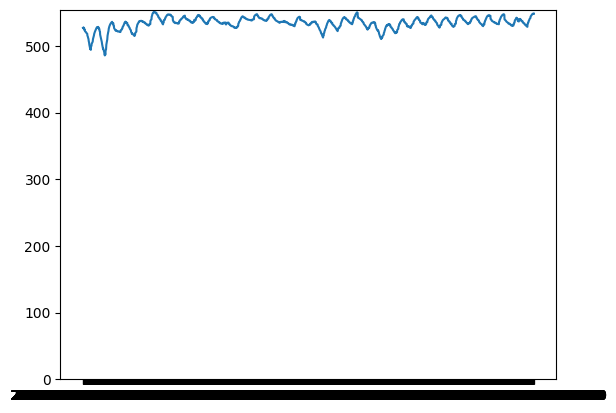

In [ ]:
df = pd.read_csv('/content/results/th_results.csv')
import matplotlib.pyplot as plt
plt.plot(df['date'],df['load'])
plt.ylim(0)
plt.show()

In [ ]:
df_features,may_temp = load_data('lsc')

In [ ]:
may_temp

,date,temp
55388,2023-05-01 00:00:00,27.8
55389,2023-05-01 00:15:00,27.8
55390,2023-05-01 00:30:00,27.8
55391,2023-05-01 00:45:00,27.8
55392,2023-05-01 01:00:00,22.2
...,...,...
58359,2023-05-31 22:45:00,27.2
58360,2023-05-31 23:00:00,28.3
58361,2023-05-31 23:15:00,28.3
58362,2023-05-31 23:30:00,28.3


In [ ]:
may_temp

,date,temp
55388,2023-05-01 00:00:00,27.8
55389,2023-05-01 00:15:00,27.8
55390,2023-05-01 00:30:00,27.8
55391,2023-05-01 00:45:00,27.8
55392,2023-05-01 01:00:00,22.2
...,...,...
58359,2023-05-31 22:45:00,27.2
58360,2023-05-31 23:00:00,28.3
58361,2023-05-31 23:15:00,28.3
58362,2023-05-31 23:30:00,28.3


In [ ]:
model.load_weights(f"lsc.hdf5")
num_time_periods = (
    NUM_TIME_PERIOD
)  # Number of 15-minute intervals in May 2023 (assuming 31 days)
sequence_length = SEQUENCE_LENGTH
rolling_forecast_input = df_features[['temp','Load']].iloc[-sequence_length:].values
X_rolling_forecast = np.array([rolling_forecast_input])

rolling_forecast_predictions = []
load_may_values = []
for i in tqdm(range(num_time_periods)):
    prediction = model.predict(X_rolling_forecast, verbose=0)
    rolling_forecast_predictions.extend(prediction[0])
    load_may_values.append(prediction[0])
    new_sample = np.append(may_temp.iloc[i,1], prediction[0])
    print(new_sample)
    new_sample = np.expand_dims(new_sample, axis=(0, 1))
    X_rolling_forecast = np.concatenate(
        [X_rolling_forecast[:, 1:, :], new_sample], axis=1
    )

inference_result = load_may_values
inference_result = pd.DataFrame(inference_result, columns=["load"])
inference_result["date"] = pd.date_range(
    start="2023-05-01", end="2023-06-01", freq="15T", inclusive="both"
)[:-1]
inference_result["location"] = 'lsc'
inference_result["temp"] = 34
inference_result = inference_result[CONSIDERED_COLUMNS]

  0%|          | 2/2976 [00:03<1:21:17,  1.64s/it]

[27.8       38.5338974]
[27.8        38.46343994]


  0%|          | 4/2976 [00:04<32:09,  1.54it/s]

[27.8        38.92037201]
[27.8        39.04869843]


  0%|          | 5/2976 [00:04<23:46,  2.08it/s]

[22.2        39.09911346]


  0%|          | 6/2976 [00:04<19:15,  2.57it/s]

[22.2        36.83087158]


  0%|          | 8/2976 [00:05<13:59,  3.53it/s]

[22.2        36.76052856]
[22.2        36.85035706]


  0%|          | 11/2976 [00:05<07:27,  6.62it/s]

[22.2        36.93341827]
[22.2        37.00949097]
[22.2        37.08720398]
[22.2        37.16592407]


  1%|          | 15/2976 [00:05<04:26, 11.13it/s]

[21.1        37.24419785]
[21.1        37.05634308]
[21.1        37.08893585]
[21.1        37.14824677]


  1%|          | 19/2976 [00:05<03:29, 14.13it/s]

[21.1        37.20609283]
[21.1        37.26369476]
[21.1        37.32271194]
[21.1        37.38304901]


  1%|          | 23/2976 [00:05<03:02, 16.16it/s]

[19.4        37.44462585]
[19.4        37.04385376]
[19.4        37.01661682]
[19.4       37.0118866]


  1%|          | 27/2976 [00:06<02:47, 17.58it/s]

[18.3        37.00743103]
[18.3        36.68876648]
[18.3        36.62209702]
[18.3        36.56249237]


  1%|          | 31/2976 [00:06<02:44, 17.90it/s]

[15.         36.50258636]
[15.         35.57063293]
[15.         35.35655975]
[15.         35.15644073]


  1%|          | 35/2976 [00:06<02:39, 18.42it/s]

[13.9        34.96794128]
[13.9        34.55231094]
[13.9        34.33727264]
[13.9        34.12625122]


  1%|▏         | 39/2976 [00:06<02:47, 17.52it/s]

[13.9        33.91875458]
[13.9        33.71009827]
[13.9        33.49968719]
[13.9        33.28849792]


  1%|▏         | 43/2976 [00:07<02:44, 17.85it/s]

[14.4        33.07719421]
[14.4        32.94997787]
[14.4        32.73893738]
[14.4        32.53114319]


  2%|▏         | 47/2976 [00:07<02:38, 18.43it/s]

[12.2       32.3266983]
[12.2        31.84473228]
[12.2        31.69898605]
[12.2        31.56255341]


  2%|▏         | 51/2976 [00:07<02:34, 18.92it/s]

[12.2        31.43997192]
[12.2       31.3268013]
[12.2        31.22284889]
[12.2        31.12825584]


  2%|▏         | 55/2976 [00:07<02:38, 18.44it/s]

[17.2        31.04257393]
[17.2        31.69670105]
[17.2        31.50530434]
[17.2        31.36538506]


  2%|▏         | 59/2976 [00:07<02:32, 19.11it/s]

[22.8        31.23522186]
[22.8        32.11411285]
[22.8        31.89502907]
[22.8        31.65016747]


  2%|▏         | 63/2976 [00:08<02:31, 19.29it/s]

[24.4        31.50357628]
[24.4        31.72841072]
[24.4        31.68294144]
[24.4        31.53952599]


  2%|▏         | 67/2976 [00:08<02:31, 19.14it/s]

[25.6        31.43609238]
[25.6        31.76404762]
[25.6        31.83645248]
[25.6        31.74538994]


  2%|▏         | 71/2976 [00:08<02:31, 19.18it/s]

[26.7        31.70656776]
[26.7        32.21426392]
[26.7      32.361763]
[26.7        32.34268951]


  3%|▎         | 75/2976 [00:08<02:31, 19.11it/s]

[26.7        32.38793945]
[26.7        32.45783234]
[26.7        32.52589417]
[26.7        32.59679031]
[28.9        32.67320251]


  3%|▎         | 80/2976 [00:08<02:29, 19.35it/s]

[28.9        33.95198059]
[28.9        34.38158417]
[28.9        34.52810287]
[28.9        34.74394989]


  3%|▎         | 84/2976 [00:09<02:34, 18.69it/s]

[28.9        34.98206329]
[28.9        35.22322083]
[28.9        35.47195435]
[28.9        35.72874451]
[28.9       35.9908371]


  3%|▎         | 90/2976 [00:09<02:30, 19.16it/s]

[28.9        36.25596237]
[28.9        36.52285004]
[28.9        36.79017639]
[28.9        37.05761719]


  3%|▎         | 94/2976 [00:09<02:29, 19.24it/s]

[28.9        37.32466507]
[28.9        37.59112549]
[28.3        37.85400391]
[28.3        37.71382904]


  3%|▎         | 98/2976 [00:09<02:29, 19.29it/s]

[28.3        37.89315796]
[28.3        38.13995361]
[27.2        38.35118103]
[27.2        37.86824036]


  3%|▎         | 102/2976 [00:10<02:45, 17.40it/s]

[27.2        37.90029907]
[27.2       38.0993576]
[24.4        38.25128937]
[24.4        37.15965271]


  3%|▎         | 104/2976 [00:10<02:39, 18.04it/s]

[24.4        37.04498291]
[24.4        37.15836334]
[21.1        37.26284027]
[21.1      36.467659]


  4%|▎         | 109/2976 [00:10<02:36, 18.36it/s]

[21.1        36.46456909]
[21.1        36.53424835]
[21.7        36.59194565]
[21.7        36.78630066]


  4%|▍         | 113/2976 [00:10<02:34, 18.51it/s]

[21.7        36.86666107]
[21.7        36.93048859]
[21.7        36.99594879]
[21.7        37.06247711]


  4%|▍         | 116/2976 [00:10<04:30, 10.58it/s]

[21.7        37.12959671]
[21.7        37.19769287]


KeyboardInterrupt: ignored

In [ ]:
X_rolling_forecast

array([[[Timestamp('2023-04-30 00:00:00'), 19.4, 32.5],
        [Timestamp('2023-04-30 00:15:00'), 19.4, 30.0],
        [Timestamp('2023-04-30 00:30:00'), 19.4, 31.5],
        [Timestamp('2023-04-30 00:45:00'), 19.4, 30.88],
        [Timestamp('2023-04-30 01:00:00'), 19.4, 30.63],
        [Timestamp('2023-04-30 01:15:00'), 19.4, 36.38],
        [Timestamp('2023-04-30 01:30:00'), 19.4, 33.88],
        [Timestamp('2023-04-30 01:45:00'), 19.4, 42.19],
        [Timestamp('2023-04-30 02:00:00'), 13.3, 31.0],
        [Timestamp('2023-04-30 02:15:00'), 13.3, 31.0],
        [Timestamp('2023-04-30 02:30:00'), 13.3, 32.81],
        [Timestamp('2023-04-30 02:45:00'), 13.3, 27.88],
        [Timestamp('2023-04-30 03:00:00'), 13.3, 35.38],
        [Timestamp('2023-04-30 03:15:00'), 13.3, 32.31],
        [Timestamp('2023-04-30 03:30:00'), 13.3, 36.94],
        [Timestamp('2023-04-30 03:45:00'), 13.3, 30.0],
        [Timestamp('2023-04-30 04:00:00'), 13.3, 36.25],
        [Timestamp('2023-04-30 04:15:

## LSTM with more layers

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse


In [387]:
temperature = pd.read_csv('/content/data/lsc_temp_w_may.csv')
load = pd.read_csv('/content/data/lsc2.csv')

if "Datetime MST" in load.columns:
    load["date"] = pd.to_datetime(load["Datetime MST"], format="%m/%d/%Y %H:%M")
elif "Datetime EST" in load.columns:
    load["date"] = pd.to_datetime(load["Datetime EST"], format="%m/%d/%Y %H:%M")
else:
    raise ValueError("Unable to find the datetime column in temp file")

temperature["date"] = pd.to_datetime(temperature["time"])

temperature.drop(["time"], axis=1, inplace=True)
temperature.set_index("date", inplace=True)

# Create a new DataFrame with the desired index
new_index = pd.date_range(start=temperature.index[0], end='2023-06-01 00:00', freq='15T')
resampled_data = pd.DataFrame(index=new_index)

# Merge the original data with the new DataFrame
temperature = resampled_data.merge(temperature, how='left', left_index=True, right_index=True)

# Forward fill to maintain the same temperature within each hour
# temperature['temp'].fillna(method='ffill',inplace=True)
temperature["temp"] = temperature["temp"].interpolate(method='linear')

# Reset the index to make 'date' a regular column
temperature.reset_index(inplace=True)
temperature.rename(columns={'index':'date'},inplace=True)

combined = pd.merge(left=load, right=temperature, on=["date"], how="left")

combined["temp"] = combined["temp"].fillna(method="ffill").fillna(method="bfill")

# Filter data out the May 2023
combined_april = combined[
    (combined["date"].dt.year == 2023) & (combined["date"].dt.month <= 5)
]

combined_may = temperature[
    (temperature["date"].dt.year == 2023) & (temperature["date"].dt.month == 5)
]

df_features = combined[["date","temp", "Load"]].dropna().reset_index(drop=True)
may_temperature = combined_may.copy(deep=True)


In [388]:
df_features.iloc[:20]

,date,temp,Load
0,2022-03-01 00:15:00,16.400,85.38
1,2022-03-01 00:30:00,15.000,82.81
2,2022-03-01 00:45:00,13.600,81.88
3,2022-03-01 01:00:00,12.200,76.50
4,2022-03-01 01:15:00,11.375,76.75
5,2022-03-01 01:30:00,10.550,79.63
6,2022-03-01 01:45:00,9.725,77.83
7,2022-03-01 02:00:00,8.900,78.00
8,2022-03-01 02:15:00,8.625,84.38
9,2022-03-01 02:30:00,8.350,86.71


In [389]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [409]:
# Sort the data by date
data = df_features.sort_values('date')
data.set_index('date', inplace=True)
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# 2. Feature Engineering
train_data['day_of_week'] = train_data.index.dayofweek
train_data['hour'] = train_data.index.hour
train_data['minute'] = train_data.index.minute
# Add lagged temperature values as features
train_data['lag_temp_1'] = train_data['temp'].shift(1)
train_data['lag_temp_2'] = train_data['temp'].shift(2)
train_data['lag_temp_3'] = train_data['temp'].shift(3)
# Add lagged time values as features
# train_data['lag_hour_1'] = train_data['hour'].shift(1)
# train_data['lag_hour_2'] = train_data['hour'].shift(2)
# train_data['lag_hour_3'] = train_data['hour'].shift(3)
# train_data['lag_minute_1'] = train_data['minute'].shift(1)
# train_data['lag_minute_2'] = train_data['minute'].shift(2)
# train_data['lag_minute_3'] = train_data['minute'].shift(3)
# Add rolling temperature features
train_data['rolling_mean_temp'] = train_data['temp'].rolling(window=3).mean()
train_data['rolling_std_temp'] = train_data['temp'].rolling(window=3).std()
# Add additional statistical features
train_data['mean_temp'] = train_data['temp'].mean()
train_data['std_temp'] = train_data['temp'].std()
train_data['max_temp'] = train_data['temp'].max()
train_data['min_temp'] = train_data['temp'].min()
# Add additional features as per your requirement
train_data['day_of_year'] = train_data.index.dayofyear
train_data['week_of_year'] = train_data.index.weekofyear
train_data['month'] = train_data.index.month
train_data['year'] = train_data.index.year
train_data['median_temp'] = train_data['temp'].median()
train_data['var_temp'] = train_data['temp'].var()
train_data['skew_temp'] = train_data['temp'].skew()
train_data['kurt_temp'] = train_data['temp'].kurt()
train_data['sum_temp'] = train_data['temp'].sum()

# Create additional features from date and time for test data
test_data['day_of_week'] = test_data.index.dayofweek
test_data['hour'] = test_data.index.hour
test_data['minute'] = test_data.index.minute
# Add lagged temperature values as features
test_data['lag_temp_1'] = test_data['temp'].shift(1)
test_data['lag_temp_2'] = test_data['temp'].shift(2)
test_data['lag_temp_3'] = test_data['temp'].shift(3)
# Add lagged time values as features
# test_data['lag_hour_1'] = test_data['hour'].shift(1)
# test_data['lag_hour_2'] = test_data['hour'].shift(2)
# test_data['lag_hour_3'] = test_data['hour'].shift(3)
# test_data['lag_minute_1'] = test_data['minute'].shift(1)
# test_data['lag_minute_2'] = test_data['minute'].shift(2)
# test_data['lag_minute_3'] = test_data['minute'].shift(3)
# Add rolling temperature features
test_data['rolling_mean_temp'] = test_data['temp'].rolling(window=3).mean()
test_data['rolling_std_temp'] = test_data['temp'].rolling(window=3).std()
# Add additional statistical features
test_data['mean_temp'] = test_data['temp'].mean()
test_data['std_temp'] = test_data['temp'].std()
test_data['max_temp'] = test_data['temp'].max()
test_data['min_temp'] = test_data['temp'].min()
# Add additional features as per your requirement
# test_data['day_of_year'] = test_data.index.dayofyear
# test_data['week_of_year'] = test_data.index.weekofyear
# test_data['month'] = test_data.index.month
# test_data['year'] = test_data.index.year
test_data['median_temp'] = test_data['temp'].median()
test_data['var_temp'] = test_data['temp'].var()
test_data['skew_temp'] = test_data['temp'].skew()
test_data['kurt_temp'] = test_data['temp'].kurt()
test_data['sum_temp'] = test_data['temp'].sum()


# 3. Model Training
# Prepare the training and testing datasets
X_train = train_data.drop(['Load'],axis=1)
y_train = train_data['Load']

<ipython-input-409-22f52d08caae>:32: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_data['week_of_year'] = train_data.index.weekofyear


In [410]:
X_train.shape


(32716, 22)

In [411]:

# 4. Model Training
# Initialize and train the LGB model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 5. Model Evaluation
# Evaluate the model on the testing set
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred,squared=False)
# print("Mean Absolute Error:", mse)

LGBMRegressor()

In [342]:
comparison = pd.DataFrame({'Actual':y_test.values,'Predict':y_pred})

In [343]:
comparison

,Actual,Predict
0,28.50,44.274258
1,32.38,45.602833
2,29.75,40.817450
3,32.25,29.640632
4,31.56,29.508884
...,...,...
8174,44.25,40.431986
8175,41.97,40.062385
8176,36.13,39.930636
8177,31.44,39.400506


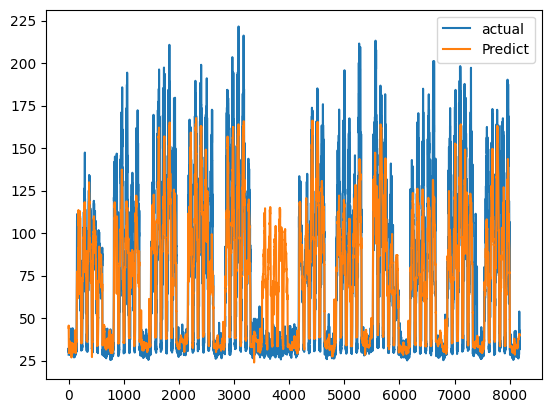

In [344]:
import matplotlib.pyplot as plt
plt.plot(comparison['Actual'],label='actual')
plt.plot(comparison['Predict'],label='Predict')
plt.legend()

In [412]:
forecast_index = pd.date_range(start='2023-05-01', periods=2976, freq='15T')
# Create a dataframe for the forecast period with temperature and additional features
forecast_data = pd.DataFrame({'temp': may_temperature['temp'],
                              'day_of_week': forecast_index.dayofweek,
                              'hour': forecast_index.hour,
                              'minute': forecast_index.minute,
                              'lag_temp_1': test_data['temp'].iloc[-1],
                              'lag_temp_2': test_data['temp'].iloc[-2],
                              'lag_temp_3': test_data['temp'].iloc[-3],
                            #   'lag_hour_1': test_data['hour'].iloc[-1],
                            #   'lag_hour_2': test_data['hour'].iloc[-2],
                            #   'lag_hour_3': test_data['hour'].iloc[-3],
                            #   'lag_minute_1': test_data['minute'].iloc[-1],
                            #   'lag_minute_2': test_data['minute'].iloc[-2],
                            #   'lag_minute_3': test_data['minute'].iloc[-3],
                              'rolling_mean_temp': test_data['temp'].rolling(window=3).mean().iloc[-3:],
                              'rolling_std_temp': test_data['temp'].rolling(window=3).std().iloc[-3:],
                              'mean_temp': test_data['temp'].mean(),
                              'std_temp': test_data['temp'].std(),
                              'max_temp': test_data['temp'].max(),
                              'min_temp': test_data['temp'].min(),
                              'day_of_year': forecast_index.dayofyear,
                              'week_of_year': forecast_index.weekofyear,
                              'month': forecast_index.month,
                              'year': forecast_index.year,
                              'median_temp': test_data['temp'].median(),
                              'var_temp': test_data['temp'].var(),
                              'skew_temp': test_data['temp'].skew(),
                              'kurt_temp': test_data['temp'].kurt(),
                              'sum_temp': test_data['temp'].sum()}, index = forecast_index)
# Scale temperature, additional features, lagged features, rolling features for forecast data
# forecast_data[['temp', 'day_of_week', 'hour', 'minute', 'lag_temp_1', 'lag_temp_2', 'lag_temp_3', 'lag_hour_1', 'lag_hour_2', 'lag_hour_3', 'lag_minute_1', 'lag_minute_2', 'lag_minute_3', 'rolling_mean_temp', 'rolling_std_temp']] = scaler.transform(
#     forecast_data[['temp', 'day_of_week', 'hour', 'minute', 'lag_temp_1', 'lag_temp_2', 'lag_temp_3', 'lag_hour_1', 'lag_hour_2', 'lag_hour_3', 'lag_minute_1', 'lag_minute_2', 'lag_minute_3', 'rolling_mean_temp', 'rolling_std_temp']]
# )

# Use the trained model to predict load values for the forecast period
forecast_load = model.predict(forecast_data)

# Create a new dataframe for the forecasted load values
forecast_result = pd.DataFrame({'Load': forecast_load}, index=forecast_index)

<ipython-input-412-c12e36b76070>:23: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  'week_of_year': forecast_index.weekofyear,


In [413]:
forecast_result

,Load
2023-05-01 00:00:00,39.548917
2023-05-01 00:15:00,39.435217
2023-05-01 00:30:00,39.435217
2023-05-01 00:45:00,39.039897
2023-05-01 01:00:00,41.056876
...,...
2023-05-31 22:45:00,102.771780
2023-05-31 23:00:00,99.916743
2023-05-31 23:15:00,96.917159
2023-05-31 23:30:00,96.917159


In [417]:
forecast_result['Load'].unique()
forecast_result['Load'].max()

141.05548937350312

<Axes: >

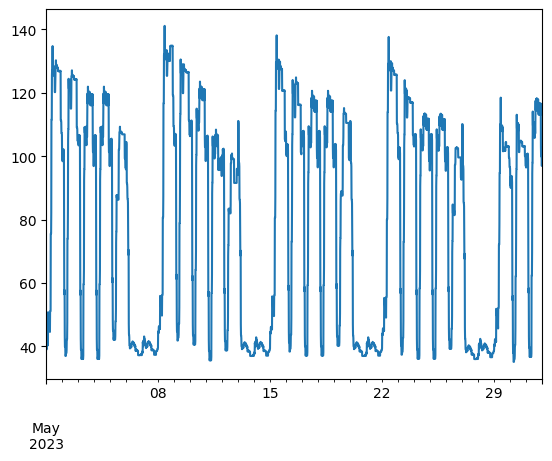

In [418]:
forecast_result['Load'].plot()

In [419]:
may_temperature.set_index('date',inplace=True)

In [420]:
may = pd.merge(left = may_temperature, right = forecast_result, left_index=True,right_index=True)
may

,temp,Load
date,,
2023-05-01 00:00:00,27.800,39.548917
2023-05-01 00:15:00,26.400,39.435217
2023-05-01 00:30:00,25.000,39.435217
2023-05-01 00:45:00,23.600,39.039897
2023-05-01 01:00:00,22.200,41.056876
...,...,...
2023-05-31 22:45:00,28.025,102.771780
2023-05-31 23:00:00,28.300,99.916743
2023-05-31 23:15:00,28.300,96.917159


In [421]:
df_features.set_index('date',inplace=True)
df_features

,temp,Load
date,,
2022-03-01 00:15:00,16.400,85.38
2022-03-01 00:30:00,15.000,82.81
2022-03-01 00:45:00,13.600,81.88
2022-03-01 01:00:00,12.200,76.50
2022-03-01 01:15:00,11.375,76.75
...,...,...
2023-04-30 22:45:00,28.900,44.25
2023-04-30 23:00:00,28.900,41.97
2023-04-30 23:15:00,28.625,36.13


In [422]:
foo = pd.concat([df_features,may],axis=0)

In [423]:
foo.to_excel('lsc_result.xlsx')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [ ]:
load_isc = pd.read_csv('/content/lsc2.csv')
temp_isc = pd.read_csv('/content/lsc_temp.csv')

load_isc['date'] = pd.to_datetime(load_isc['Datetime MST'], format='%m/%d/%Y %H:%M')
temp_isc['date'] = pd.to_datetime(temp_isc['time'])

# Set the 'date' column as the DataFrame's index
temp_isc.set_index('date', inplace=True)
temp_isc.drop(['time'],axis=1,inplace=True)

# Resample the DataFrame at 15-minute intervals and forward fill any missing values
df_resampled = temp_isc.asfreq('15T')

# Reset the index to make the 'date' column a regular column again
df_resampled.reset_index(inplace=True)

# Repeat the load values for each 15-minute interval
df_resampled['temp'].fillna(method='ffill',inplace=True)

# merging the dataframes
isc = pd.merge(left=load_isc,right=df_resampled,on=['date'],how='inner')
isc.drop(['Datetime MST'],inplace=True,axis=1)

df_features = pd.DataFrame()
df_features['temp'] = isc['temp']
df_features['Load'] = isc['Load']

# Drop rows with missing values
df_features.dropna(inplace=True)

# Split the data into input (X) and target (y) arrays
X = []
y = []
sequence_length = 4* 24  # a day
for i in range(sequence_length, len(df_features)):
    X.append(df_features.iloc[i-sequence_length:i, :].values)
    y.append(df_features.loc[i,"Load"])  # Target is the 'Load' column

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
model_save = ModelCheckpoint('isc.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(x_train, y_train, epochs=200, batch_size=128, validation_split = 0.1, callbacks =[earlyStopping, model_save])

# plotting the training and val loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

# Loading the best model
model.load_weights('isc.hdf5')

# Evaluate the model on the test set
loss = model.evaluate(x_test, y_test)
print('Test loss:', loss)

# Make predictions on the test set
predictions = model.predict(x_test)

# Compare predictions with actual values
comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
metric = mse(comparison['Actual'],comparison['Predicted'],squared=False)
print(f"the metric is {round(metric,2)}")

# Perform rolling forecast inference for May 2023
num_time_periods = 4 * 24 * 31  # Number of 15-minute intervals in May 2023 (assuming 31 days)
sequence_length = 4 * 24
rolling_forecast_input = df_features.iloc[-sequence_length:].values
X_rolling_forecast = np.array([rolling_forecast_input])

rolling_forecast_predictions = []
for i in range(num_time_periods // sequence_length):
    prediction = model.predict(X_rolling_forecast)
    rolling_forecast_predictions.extend(prediction[0])
    foo = np.append(34, prediction[0])
    foo = np.expand_dims(foo, axis=(0,1))
    X_rolling_forecast = np.concatenate([X_rolling_forecast[:, 1:, :], foo], axis=1)

cols = ['date','temp','load','location']
inference_result = X_rolling_forecast[:,-31:]
inference_result = pd.DataFrame(inference_result[0],columns=['temp','load'])
inference_result['date'] = pd.date_range(start='2023-05-01',end='2023-05-31',freq='D')
inference_result['location'] = 'LSC'
inference_result = inference_result[cols]
inference_result



## Selecting and tunning the model

In [ ]:
df_features = pd.DataFrame()
df_features['temp'] = isc['temp']
df_features['Load'] = isc['Load']

# Drop rows with missing values
df_features.dropna(inplace=True)

# Split the data into input (X) and target (y) arrays
X = []
y = []
sequence_length = 4* 24  # a day
for i in range(sequence_length, len(df_features)):
    X.append(df_features.iloc[i-sequence_length:i, :].values)
    y.append(df_features.loc[i,"Load"])  # Target is the 'Load' column

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
model_save = ModelCheckpoint('isc.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(x_train, y_train, epochs=200, batch_size=128, validation_split = 0.1, callbacks =[earlyStopping, model_save])

# plotting the training and val loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

# Loading the best model
model.load_weights('isc.hdf5')

# Evaluate the model on the test set
loss = model.evaluate(x_test, y_test)
print('Test loss:', loss)

# Make predictions on the test set
predictions = model.predict(x_test)

# Compare predictions with actual values
comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
metric = mse(comparison['Actual'],comparison['Predicted'],squared=False)
print(f"the metric is {round(metric,2)}")

# Perform rolling forecast inference for May 2023
num_time_periods = 4 * 24 * 31  # Number of 15-minute intervals in May 2023 (assuming 31 days)
sequence_length = 4 * 24
rolling_forecast_input = df_features.iloc[-sequence_length:].values
X_rolling_forecast = np.array([rolling_forecast_input])

rolling_forecast_predictions = []
for i in range(num_time_periods // sequence_length):
    prediction = model.predict(X_rolling_forecast)
    rolling_forecast_predictions.extend(prediction[0])
    foo = np.append(34, prediction[0])
    foo = np.expand_dims(foo, axis=(0,1))
    X_rolling_forecast = np.concatenate([X_rolling_forecast[:, 1:, :], foo], axis=1)

cols = ['date','temp','load','location']
inference_result = X_rolling_forecast[:,-31:]
inference_result = pd.DataFrame(inference_result[0],columns=['temp','load'])
inference_result['date'] = pd.date_range(start='2023-05-01',end='2023-05-31',freq='D')
inference_result['location'] = 'LSC'
inference_result = inference_result[cols]
inference_result


## Refactored code

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

def load_data():
    load_isc = pd.read_csv('/content/lsc2.csv')
    temp_isc = pd.read_csv('/content/lsc_temp.csv')

    load_isc['date'] = pd.to_datetime(load_isc['Datetime MST'], format='%m/%d/%Y %H:%M')
    temp_isc['date'] = pd.to_datetime(temp_isc['time'])

    # temp_isc.set_index('date', inplace=True)
    temp_isc.drop(['time'], axis=1, inplace=True)

    isc = pd.merge(left=load_isc, right=temp_isc, on=['date'], how='left')
    isc['temp'] = isc['temp'].fillna(method='ffill').fillna(method='bfill')
    isc = isc[isc['date'].dt.strftime('%Y-%m') <= '2023-05']

    df_features = isc[['temp','Load']]

    df_features.dropna(inplace=True)

    return df_features

def preprocess_data(df_features):
    X = []
    y = []
    sequence_length = 4 * 24  # a day

    for i in range(sequence_length, len(df_features)):
        X.append(df_features.iloc[i-sequence_length:i, :].values)
        y.append(df_features.loc[i, "Load"])

    X = np.array(X)
    y = np.array(y)

    return X, y

def split_data(X, y):
    train_size = int(0.8 * len(X))
    x_train, x_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return x_train, x_test, y_train, y_test

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=32))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

def train_model(model, x_train, y_train):
    earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
    model_save = ModelCheckpoint('isc.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    history = model.fit(x_train, y_train, epochs=200, batch_size=128, validation_split=0.1, callbacks=[earlyStopping, model_save])

    return history

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

def evaluate_model(model, x_test, y_test):
    loss = model.evaluate(x_test, y_test)
    print('Test loss:', loss)

def make_predictions(model, x_test):
    predictions = model.predict(x_test)
    return predictions

def calculate_metric(y_test, predictions):
    comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
    metric = mse(comparison['Actual'], comparison['Predicted'], squared=False)
    print(f"The metric is {round(metric, 2)}")

def perform_rolling_forecast(model, df_features):
    model.load_weights('isc.hdf5')
    num_time_periods = 4 * 24 * 31  # Number of 15-minute intervals in May 2023 (assuming 31 days)
    sequence_length = 4 * 24
    rolling_forecast_input = df_features.iloc[-sequence_length:].values
    X_rolling_forecast = np.array([rolling_forecast_input])

    rolling_forecast_predictions = []
    load_may_values = []
    for i in range(num_time_periods):
        prediction = model.predict(X_rolling_forecast,verbose=2)
        rolling_forecast_predictions.extend(prediction[0])
        load_may_values.append(prediction[0])
        new_sample = np.append(34, prediction[0])
        new_sample = np.expand_dims(new_sample, axis=(0,1))
        X_rolling_forecast = np.concatenate([X_rolling_forecast[:, 1:, :], new_sample], axis=1)

    cols = ['date', 'temp', 'load', 'location']
    inference_result = load_may_values
    inference_result = pd.DataFrame(inference_result, columns=['load'])
    inference_result['date'] = pd.date_range(start='2023-05-01', end='2023-06-01', freq='15T', inclusive='both')[:-1]
    inference_result['location'] = 'LSC'
    inference_result['temp'] = 34
    inference_result = inference_result[cols]

    return inference_result

# Load and preprocess data
df_features = load_data()
# X, y = preprocess_data(df_features)

# # Split the data into training and testing sets
# x_train, x_test, y_train, y_test = split_data(X, y)

# # Build the LSTM model
# model = build_model((x_train.shape[1], x_train.shape[2]))

# # Train the model
# history = train_model(model, x_train, y_train)

# # Plot the training and validation loss
# plot_loss(history)

# # Evaluate the model on the test set
# evaluate_model(model, x_test, y_test)

# # Make predictions on the test set
# predictions = make_predictions(model, x_test)

# # Calculate the metric
# calculate_metric(y_test, predictions)

# # Build the LSTM model
# model_retrain = build_model((X.shape[1], X.shape[2]))

# # Model retrain on whole dataset
# history_retrain = train_model(model_retrain, X, y)

# # Perform rolling forecast inference for May 2023
# inference_result = perform_rolling_forecast(model, df_features)


In [ ]:
df_features

,temp,Load
2975,22.8,103.63
5855,28.3,36.75
8831,31.1,158.13
11711,27.2,111.63
14687,32.8,71.04
17663,25.0,140.92
20543,26.1,97.29
23519,20.6,70.13
26399,11.7,84.63
29375,17.8,32.25


<ipython-input-49-ec3bbf87101a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.dropna(inplace=True)


In [ ]:
temp_isc

,temp
date,
2021-10-01 01:00:00,26.1
2021-10-01 02:00:00,25.0
2021-10-01 03:00:00,24.4
2021-10-01 04:00:00,23.9
2021-10-01 05:00:00,23.9
...,...
2023-04-30 19:00:00,27.8
2023-04-30 20:00:00,28.9
2023-04-30 21:00:00,28.9


In [ ]:
num_time_periods = 4 * 24 * 31  # Number of 15-minute intervals in May 2023 (assuming 31 days)
sequence_length = 4 * 24
rolling_forecast_input = df_features.iloc[-sequence_length:].values
X_rolling_forecast = np.array([rolling_forecast_input])

rolling_forecast_predictions = []
load_may_values = []
for i in range(num_time_periods):
    prediction = model.predict(X_rolling_forecast,verbose=2)
    rolling_forecast_predictions.extend(prediction[0])
    load_may_values.append(prediction[0])
    new_sample = np.append(34, prediction[0])
    new_sample = np.expand_dims(new_sample, axis=(0,1))
    X_rolling_forecast = np.concatenate([X_rolling_forecast[:, 1:, :], new_sample], axis=1)

# cols = ['date', 'temp', 'load', 'location']
# inference_result = load_may_values
# inference_result = pd.DataFrame(inference_result, columns=['load'])
# inference_result['date'] = pd.date_range(start='2023-05-01', end='2023-05-31', freq='15min')
# inference_result['location'] = 'LSC'
# inference_result['temp'] = 34
# inference_result = inference_result[cols]

In [ ]:
cols = ['date', 'temp', 'load', 'location']
inference_result = load_may_values
inference_result = pd.DataFrame(inference_result, columns=['load'])
inference_result['date'] = pd.date_range(start='2023-05-01', end='2023-06-01', freq='15T', inclusive='both')[:-1]
inference_result['location'] = 'LSC'
inference_result['temp'] = 34
inference_result = inference_result[cols]

<Axes: >

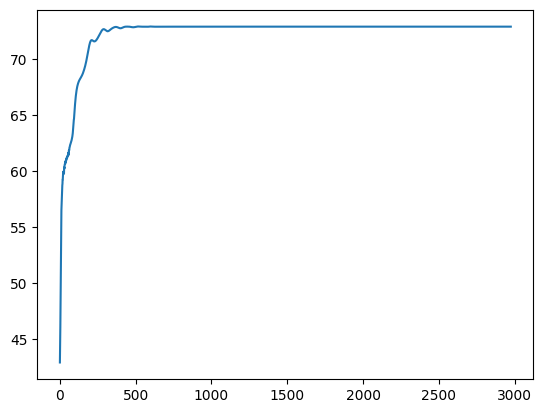

In [ ]:
inference_result['load'].plot()


In [ ]:
pd.date_range(start='2023-05-01', end='2023-05-31', freq='15T').nunique()

2881

In [ ]:
x = pd.concat([df_features['Load'],inference_result['load']],axis=0)

(0.0, 65.64721450805663)

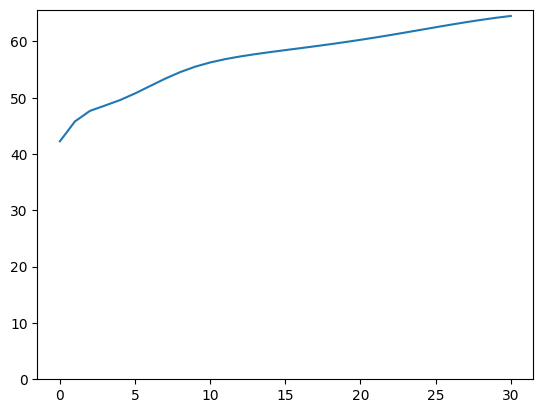

In [ ]:
plt.plot(x.iloc[-31:])
plt.ylim(0)

In [ ]:
x

0     85.380000
1     82.810000
2     81.880000
3     76.500000
4     76.750000
        ...    
26    62.979698
27    63.416534
28    63.825817
29    64.199921
30    64.533829
Length: 40923, dtype: float64

In [ ]:
inference_result

,date,temp,load,location
0,2023-05-01,34.0,42.266113,LSC
1,2023-05-02,34.0,45.795799,LSC
2,2023-05-03,34.0,47.673519,LSC
3,2023-05-04,34.0,48.619858,LSC
4,2023-05-05,34.0,49.588985,LSC
5,2023-05-06,34.0,50.771233,LSC
6,2023-05-07,34.0,52.082592,LSC
7,2023-05-08,34.0,53.387001,LSC
8,2023-05-09,34.0,54.557224,LSC
9,2023-05-10,34.0,55.520020,LSC


In [ ]:
import unittest
import numpy as np
import pandas as pd
from upwork import *

class TestMyModule(unittest.TestCase):

    def setUp(self):
        self.df_features = pd.DataFrame({'temp': [1, 2, 3, 4, 5], 'Load': [10, 20, 30, 40, 50]})

    def test_load_data(self):
        df_features = load_data()
        self.assertIsInstance(df_features, pd.DataFrame)
        self.assertEqual(len(df_features), 5)

    def test_preprocess_data(self):
        X, y = preprocess_data(self.df_features)
        self.assertIsInstance(X, np.ndarray)
        self.assertIsInstance(y, np.ndarray)
        self.assertEqual(X.shape, (1, 4, 2))
        self.assertEqual(y.shape, (1,))

    def test_split_data(self):
        X = np.array([[[1, 10], [2, 20], [3, 30], [4, 40]]])
        y = np.array([50])
        x_train, x_test, y_train, y_test = split_data(X, y)
        self.assertIsInstance(x_train, np.ndarray)
        self.assertIsInstance(x_test, np.ndarray)
        self.assertIsInstance(y_train, np.ndarray)
        self.assertIsInstance(y_test, np.ndarray)
        self.assertEqual(x_train.shape, (1, 3, 2))
        self.assertEqual(x_test.shape, (1, 1, 2))
        self.assertEqual(y_train.shape, (1,))
        self.assertEqual(y_test.shape, (1,))

    def test_build_model(self):
        model = build_model((3, 2))
        self.assertIsNotNone(model)

    def test_train_model(self):
        x_train = np.random.rand(10, 3, 2)
        y_train = np.random.rand(10,)
        model = build_model((3, 2))
        history = train_model(model, x_train, y_train)
        self.assertIsNotNone(history)

    def test_make_predictions(self):
        x_test = np.random.rand(1, 3, 2)
        model = build_model((3, 2))
        predictions = make_predictions(model, x_test)
        self.assertIsInstance(predictions, np.ndarray)
        self.assertEqual(predictions.shape, (1, 1))

    def test_calculate_metric(self):
        y_test = np.array([100])
        predictions = np.array([90])
        metric = calculate_metric(y_test, predictions)
        self.assertIsInstance(metric, float)

    def test_perform_rolling_forecast(self):
        df_features = pd.DataFrame({'temp': [1, 2, 3, 4, 5], 'Load': [10, 20, 30, 40, 50]})
        model = build_model((4, 2))
        inference_result = perform_rolling_forecast(model, df_features)
        self.assertIsInstance(inference_result, pd.DataFrame)
        self.assertEqual(len(inference_result), 31)

if __name__ == '__main__':
    unittest.main()


E
ERROR: /root/ (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/root/'

----------------------------------------------------------------------
Ran 1 test in 0.005s

FAILED (errors=1)


SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
isc.iloc[-96:]

,date,temp,Load
40796,2023-04-29 23:15:00,20.6,29.63
40797,2023-04-29 23:30:00,20.6,28.81
40798,2023-04-29 23:45:00,20.6,34.31
40799,2023-04-30 00:00:00,19.4,32.50
40800,2023-04-30 00:15:00,19.4,30.00
...,...,...,...
40887,2023-04-30 22:00:00,28.9,31.50
40888,2023-04-30 22:15:00,28.9,43.50
40889,2023-04-30 22:30:00,28.9,53.88
40890,2023-04-30 22:45:00,28.9,44.25


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Make predictions on the test set
predictions = model.predict(x_test)

# Inverse scale the predictions and actual values
# predictions = scaler.inverse_transform(predictions[:, -1].reshape(-1, 1))
# actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare predictions with actual values
comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
print(comparison)

255/255 [==============================] - 2s 6ms/step
      Actual  Predicted
0      30.94  32.767475
1      29.69  33.063366
2      30.50  32.685871
3      32.19  32.638363
4      33.25  33.096764
...      ...        ...
8155   31.50  35.825974
8156   43.50  35.467789
8157   53.88  38.769192
8158   44.25  42.419788
8159   41.97  44.391804

[8160 rows x 2 columns]


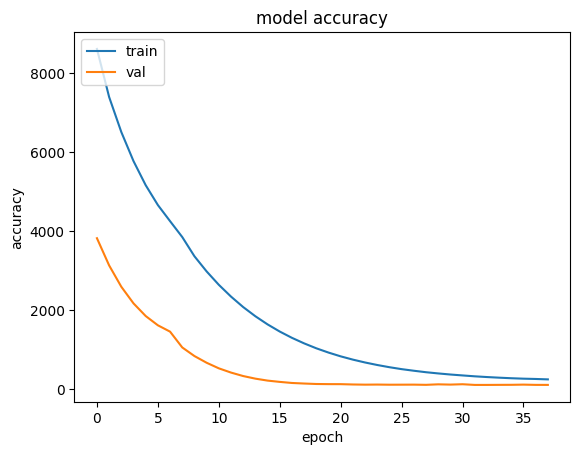

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('isc.hdf5')

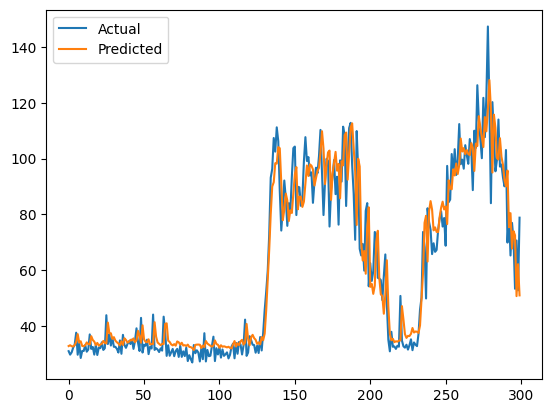

In [ ]:
import matplotlib.pyplot as plt

plt.plot(comparison['Actual'].iloc[:300],label='Actual')
plt.plot(comparison['Predicted'].iloc[:300],label='Predicted')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error as mse
mse(comparison['Actual'],comparison['Predicted'],squared=False)


12.361418459896674

In [ ]:
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

ValueError: ignored

In [ ]:
comparison = pd.DataFrame({'Actual': actual_values.flatten(), 'Predicted': predictions.flatten()})

In [ ]:
print(comparison)

        Actual  Predicted
0     0.538614   79.76432
1     0.538614   79.76432
2     0.538614   79.76432
3     0.449505   79.76432
4     0.449505   79.76432
...        ...        ...
8155  0.758416   79.76432
8156  0.758416   79.76432
8157  0.758416   79.76432
8158  0.758416   79.76432
8159  0.758416   79.76432

[8160 rows x 2 columns]


In [ ]:
# Inverse scale the predictions and actual values
predictions1 = y_scaler.inverse_transform(predictions[:, -1].reshape(-1, 1))
actual_values = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare predictions with actual values
comparison = pd.DataFrame({'Actual': actual_values.flatten(), 'Predicted': predictions1.flatten()})
print(comparison)

        Actual  Predicted
0     0.538614   0.531591
1     0.538614   0.531352
2     0.538614   0.531123
3     0.449505   0.531024
4     0.449505   0.492970
...        ...        ...
8155  0.758416   0.747884
8156  0.758416   0.747473
8157  0.758416   0.747783
8158  0.758416   0.747947
8159  0.758416   0.747177

[8160 rows x 2 columns]


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(comparison['Actual'], comparison['Predicted'],squared=False)

13.752153613859022

In [ ]:
df['Load'].mean()

80.32800865695002

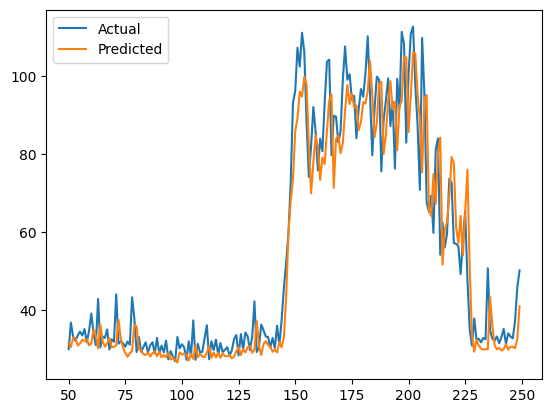

In [ ]:
import matplotlib.pyplot as plt

plt.plot(comparison['Actual'].iloc[50:250],label='Actual')
plt.plot(comparison['Predicted'].iloc[50:250],label='Predicted')
plt.legend()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
import tensorflow as tf


# Create a new DataFrame with the required features (temp and previous Load values)
df_features = pd.DataFrame()
df_features['temp'] = isc['temp']
df_features['prev_load'] = isc['Load']

# Drop rows with missing values
df_features.dropna(inplace=True)

# Normalize the feature data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_features)

# Split the data into input (X) and target (y) arrays
X = []
y = []
sequence_length = 4  # Number of previous Load values to consider
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, :])
    y.append(scaled_data[i, 0])  # Target is the 'temp' column

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Normalize the target variable using MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Attention mechanism layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(shape=(input_shape[1], 1), initializer="zeros")

    def call(self, inputs):
        e = tf.keras.activations.tanh(tf.keras.backend.dot(inputs, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = inputs * a
        return output

# Build the LSTM model with Attention mechanism
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(TimeDistributed(Dense(1)))
model.add(AttentionLayer())
model.add(TimeDistributed(Dense(1, activation='relu')))  # Change the activation function here
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print('Test loss:', loss)

# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = y_scaler.inverse_transform(predictions[:, -1, 0].reshape(-1, 1))
actual_values = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare predictions with actual values
comparison = pd.DataFrame({'Actual': actual_values.flatten(), 'Predicted': predictions.flatten()})
print(comparison)


Epoch 1/10
1023/1023 [==============================] - 8s 5ms/step - loss: 0.0219
Epoch 2/10
1023/1023 [==============================] - 6s 6ms/step - loss: 9.8256e-04
Epoch 3/10
1023/1023 [==============================] - 5s 5ms/step - loss: 6.9157e-04
Epoch 4/10
1023/1023 [==============================] - 6s 6ms/step - loss: 6.3611e-04
Epoch 5/10
1023/1023 [==============================] - 5s 5ms/step - loss: 6.0428e-04
Epoch 6/10
1023/1023 [==============================] - 6s 6ms/step - loss: 5.4434e-04
Epoch 7/10
1023/1023 [==============================] - 6s 6ms/step - loss: 4.7883e-04
Epoch 8/10
1023/1023 [==============================] - 5s 5ms/step - loss: 4.4953e-04
Epoch 9/10
1023/1023 [==============================] - 6s 6ms/step - loss: 4.2200e-04
Epoch 10/10
256/256 [==============================] - 2s 4ms/step - loss: 3.2262e-04
Test loss: 0.00032262265449389815
256/256 [==============================] - 2s 4ms/step
        Actual  Predicted
0     0.471287   0.4

In [ ]:
X

array([[[0.53861386, 0.32611436],
        [0.53861386, 0.31629808],
        [0.53861386, 0.31274588],
        [0.42772277, 0.29219663]],

       [[0.53861386, 0.31629808],
        [0.53861386, 0.31274588],
        [0.42772277, 0.29219663],
        [0.42772277, 0.29315152]],

       [[0.53861386, 0.31274588],
        [0.42772277, 0.29219663],
        [0.42772277, 0.29315152],
        [0.42772277, 0.30415187]],

       ...,

       [[0.75841584, 0.10935411],
        [0.75841584, 0.13345556],
        [0.75841584, 0.12031626],
        [0.75841584, 0.16615103]],

       [[0.75841584, 0.13345556],
        [0.75841584, 0.12031626],
        [0.75841584, 0.16615103],
        [0.75841584, 0.2057981 ]],

       [[0.75841584, 0.12031626],
        [0.75841584, 0.16615103],
        [0.75841584, 0.2057981 ],
        [0.75841584, 0.1690157 ]]])

In [ ]:
X[0]

array([[17.8 , 85.38],
       [17.8 , 82.81],
       [17.8 , 81.88],
       [12.2 , 76.5 ]])

In [ ]:
y[0]

76.75

In [ ]:
comparison

,Actual,Predicted
0,32.25,28.485621
1,32.31,29.403103
2,29.88,31.147537
3,28.50,29.331842
4,32.38,27.531767
...,...,...
8173,34.94,29.182782
8174,31.50,32.359917
8175,43.50,31.719794
8176,53.88,38.152484


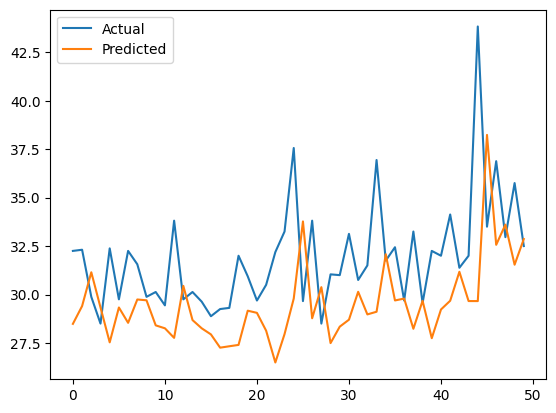

In [ ]:
import matplotlib.pyplot as plt

plt.plot(comparison['Actual'].iloc[:50],label='Actual')
plt.plot(comparison['Predicted'].iloc[:50],label='Predicted')
plt.legend()